- Normalize by frgscale
- Compute the nightly smooth sky using a Gaussian filter with sigma=120 pixel (applied on nightly median sky)
- Median stacking of the smooth-sky-subtracted images

In [1]:
from __future__ import division, print_function
import sys, os, glob, time, warnings, gc
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, vstack, hstack
import fitsio
from astropy.io import fits
import healpy as hp
from astropy import wcs

from scipy.interpolate import interp2d
from scipy.ndimage.filters import gaussian_filter

params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'figure.facecolor':'w'} 
plt.rcParams.update(params)

In [2]:
nmad = lambda x: 1.4826 * np.median(np.abs(x-np.median(x)))

ccdnamenumdict = {'S1': 25, 'S2': 26, 'S3': 27, 'S4':28,
                  'S5': 29, 'S6': 30, 'S7': 31,
                  'S8': 19, 'S9': 20, 'S10': 21, 'S11': 22, 'S12': 23,
                  'S13': 24,
                  'S14': 13, 'S15': 14, 'S16': 15, 'S17': 16, 'S18': 17,
                  'S19': 18,
                  'S20': 8, 'S21': 9, 'S22': 10, 'S23': 11, 'S24': 12,
                  'S25': 4, 'S26': 5, 'S27': 6, 'S28': 7,
                  'S29': 1, 'S30': 2, 'S31': 3,
                  'N1': 32, 'N2': 33, 'N3': 34, 'N4': 35,
                  'N5': 36, 'N6': 37, 'N7': 38,
                  'N8': 39, 'N9': 40, 'N10': 41, 'N11': 42, 'N12': 43,
                  'N13': 44,
                  'N14': 45, 'N15': 46, 'N16': 47, 'N17': 48, 'N18': 49,
                  'N19': 50,
                  'N20': 51, 'N21': 52, 'N22': 53, 'N23': 54, 'N24': 55,
                  'N25': 56, 'N26': 57, 'N27': 58, 'N28': 59,
                  'N29': 60, 'N30': 61, 'N31': 62,
                  }

fringe_dir = '/global/homes/d/djschleg/cosmo/staging/decam/DECam_CP-Fringe'
image_dir = '/global/project/projectdirs/cosmo/staging/'
surveyccd_path = '/global/project/projectdirs/cosmo/work/legacysurvey/dr9/survey-ccds-decam-dr9-cut.fits.gz'
blob_dir = '/global/project/projectdirs/desi/users/rongpu/dr9/decam_ccd_blob_mask'

In [3]:
# Choose one CCD
hdu_index = 28

In [4]:
# Load CCD list
ccd_columns = ['image_filename', 'image_hdu', 'expnum', 'ccdname', 'filter', 'mjd_obs', 'ra', 'dec', 'skyrms', 'ccdraoff', 'ccddecoff', 'ccd_cuts']
ccd = fitsio.read(surveyccd_path, columns=ccd_columns)
# ccd = fitsio.read(surveyccd_path)
ccd = Table(ccd)
mask = ccd['ccd_cuts']==0
mask &= ccd['filter']=='z' # include only z-band images
ccd = ccd[mask]
print(len(ccd), 'CCD')

# Find CCDs around some MJD
mask = (ccd['mjd_obs']>(57815-4)) & (ccd['mjd_obs']<(57815+4)) # DECaLS observing run starting Feb 28, 2017
mask |= ((ccd['mjd_obs']>(58359-2)) & (ccd['mjd_obs']<(58359+27))) # Starting Aug 28, 2018
mask |= ((ccd['mjd_obs']>(58423-2)) & (ccd['mjd_obs']<(58423+30))) # Two runs starting Oct 28, 2018
mask |= ((ccd['mjd_obs']>(57893-2)) & (ccd['mjd_obs']<(57893+30))) # Two runs starting May 18, 2017
ccd = ccd[mask]
print(len(ccd))

mask = ccd['image_hdu']==hdu_index
ccd = ccd[mask]
print(len(ccd))

1148265 CCD
164459
2706


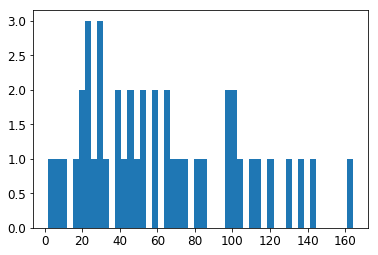

In [5]:
# Identify the observing date of each CCD
str_loc = np.char.find(np.array(ccd['image_filename'], dtype='str'), '/CP201')
ccd['obs_date'] = np.array([ccd['image_filename'][i][str_loc[i]+1:str_loc[i]+11] for i in range(len(ccd))])
t = Table()
t['date'], t['counts'] = np.unique(ccd['obs_date'], return_counts=True)
t.sort('counts')
# print(t)

plt.hist(t['counts'], 50);

In [6]:
# Require a minimum number of CCDs (since scipy gaussian_filter does not handle NAN)
mask = t['counts']<50
mask_remove = np.in1d(ccd['obs_date'], t['date'][mask])
ccd = ccd[~mask_remove]
print(len(ccd))

2156


In [7]:
# Find the CCDs whose blobmask files exist
ccd_mask = np.zeros(len(ccd), dtype=bool)
for ccd_index in range(len(ccd)):
    str_loc = str.find(ccd['image_filename'][ccd_index].strip(), '.fits')
    img_filename_base = ccd['image_filename'][ccd_index].strip()[:str_loc]
    blob_path = os.path.join(blob_dir, 'blob_mask', img_filename_base+'-blobmask.npz')
    if os.path.isfile(blob_path):
        ccd_mask[ccd_index] = True
print(np.sum(ccd_mask)/len(ccd_mask))
ccd = ccd[ccd_mask]
print(len(ccd))

0.724953617811
1563


In [10]:
# Compute the median stacked image for one specific night
np.random.seed(123)
obs_date = np.random.choice(ccd['obs_date'])
ccd_mask = ccd['obs_date']==obs_date
print(obs_date+':', np.sum(ccd_mask), 'CCDs')

img_list = []

for index, ccd_index in enumerate(np.where(ccd_mask)[0]):
    print(index)
    
    # Load CCD image
    img_fn = os.path.join(image_dir, ccd['image_filename'][ccd_index]).strip()
    hdulist = fits.open(img_fn)
    # Some images do not have FRGSCALE in the header
    try:
        frgscale = (hdulist[ccd['image_hdu'][ccd_index]].header)['FRGSCALE']
    except:
        continue
    # w = wcs.WCS(hdulist[ccd['image_hdu'][ccd_index]].header)
    img = hdulist[ccd['image_hdu'][ccd_index]].data
    
    # Load fringe image
    ccdnum = str(ccdnamenumdict[ccd[ccd_index]['ccdname'].strip()]).zfill(2)
    fringe_path = os.path.join(fringe_dir, 'DES17B_20180103_908c062-z-{}_frg.fits'.format(ccdnum))
    fringe = fits.getdata(fringe_path)
    # remove the edge pixels
    fringe = fringe[1:4095, 1:2047]
    
    # Back out the exisiting fringe correction
    img += fringe*frgscale
    
    # Load blob mask
    str_loc = str.find(ccd['image_filename'][ccd_index].strip(), '.fits')
    img_filename_base = ccd['image_filename'][ccd_index].strip()[:str_loc]
    blob_path = os.path.join(blob_dir, 'blob_mask', img_filename_base+'-blobmask.npz')
    blob_data = np.load(blob_path)
    blob = blob_data['hdu'+str(hdu_index).zfill(2)]
    
    # Remove mediam sky
    sky = np.median(img[blob].flatten())
    img = img - sky
    
    # Normalize by frgscale
    img = img/frgscale
    
    # Apply blob mask
    img[~blob] = np.nan

    img_list.append(img)

CP20170305: 115 CCDs
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114


In [20]:
img_median = np.nanmedian(img_list, axis=0)
img_mean = np.nanmean(img_list, axis=0)

# 3-sigma clipping
sky_nmad = nmad(img_median[np.isfinite(img_median)]) # sky level
mask = (img_median<-3*sky_nmad) | (img_median>3*sky_nmad)
img_median1 = img_median.copy()
img_median1[mask] = 0

# Fill in NAN values
mask = ~np.isfinite(img_median)
img_median[mask] = 0
img_median1[mask] = 0
img_mean[mask] = 0
print('number of NAN pixels:', np.sum(mask))

number of NAN pixels: 0


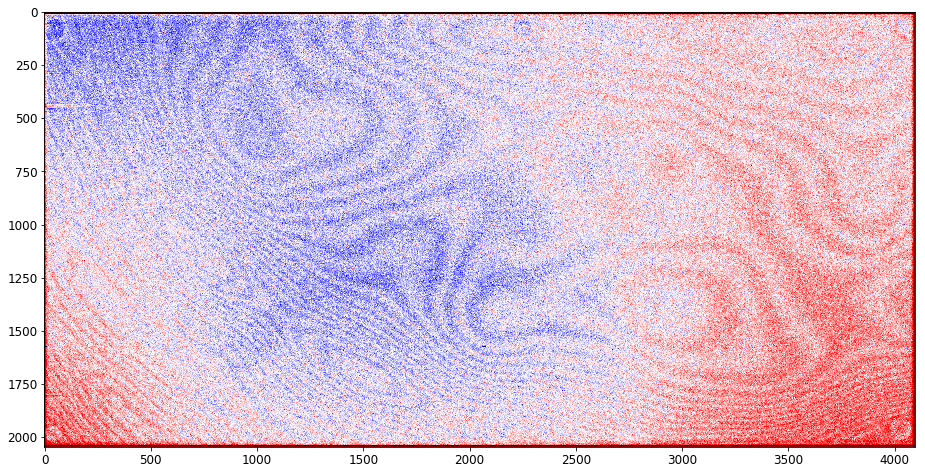

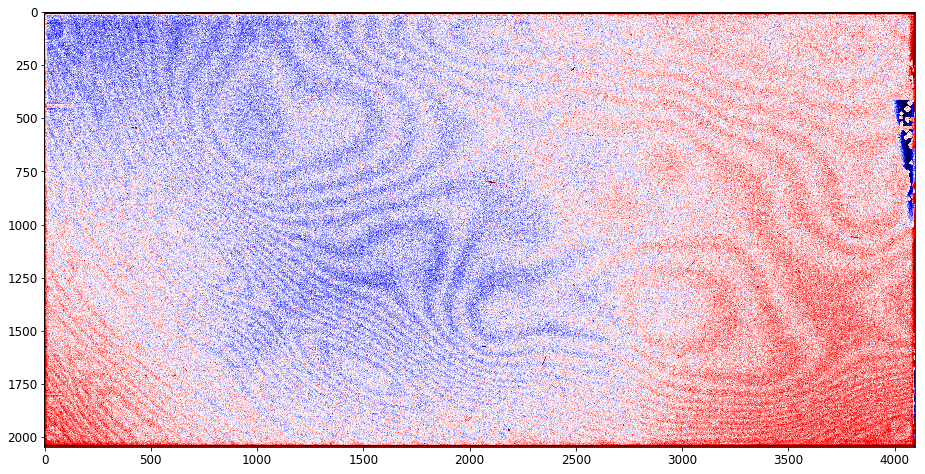

In [21]:
vrange = 1e-2

plt.figure(figsize=(17, 8))
plt.imshow((img_median).T, cmap='seismic', vmin=-vrange, vmax=vrange)
plt.show()

plt.figure(figsize=(17, 8))
plt.imshow((img_mean).T, cmap='seismic', vmin=-vrange, vmax=vrange)
plt.show()

In [22]:
# Remove the large-scale smooth component with gaussian filter

# trim edges
trim_size = 11   # trimmed imagee size need to be multiples of binsize
img_median1 = img_median1[trim_size:(img_median1.shape[0]-trim_size), trim_size:(img_median1.shape[1]-trim_size)]

# downsize the image to speed up gaussian filter
binsize = 1  # no downsizing
# img_median1 = img_median1.reshape((img_median1.shape[0]//binsize, binsize, img_median1.shape[1]//binsize,-1)).mean(axis=3).mean(1)
x_small_grid = trim_size + binsize/2+binsize*np.arange(img_median1.shape[1])
y_small_grid = trim_size + binsize/2+binsize*np.arange(img_median1.shape[0])

# Gaussian filtering
img_median1_smooth = gaussian_filter(img_median1, 120, mode='reflect')

# Convert the downsized smooth image to full size
interp_func = interp2d(x_small_grid, y_small_grid, img_median1_smooth, kind='linear')
x_grid, y_grid = np.arange(img.shape[1]), np.arange(img.shape[0])
img_median_smooth = interp_func(x_grid, y_grid).reshape(img.shape)

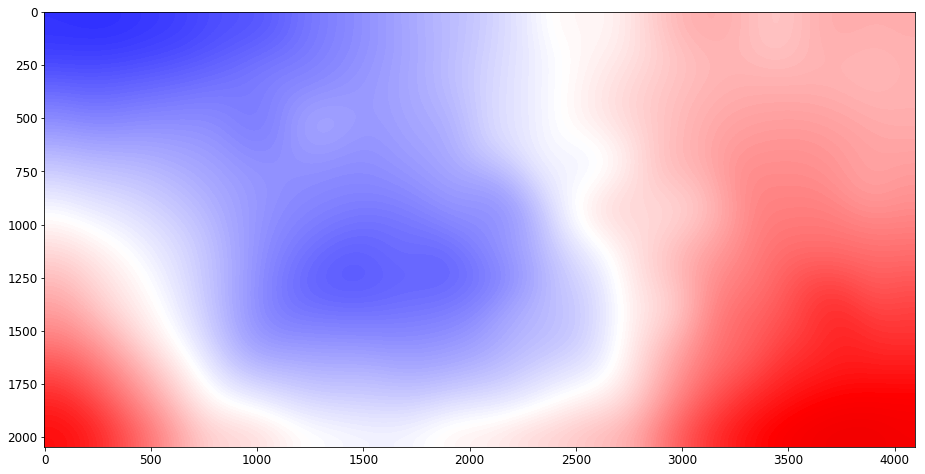

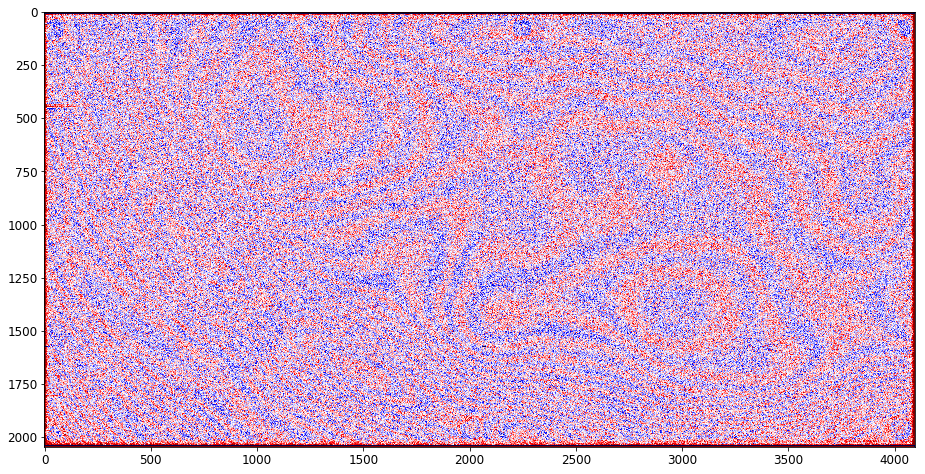

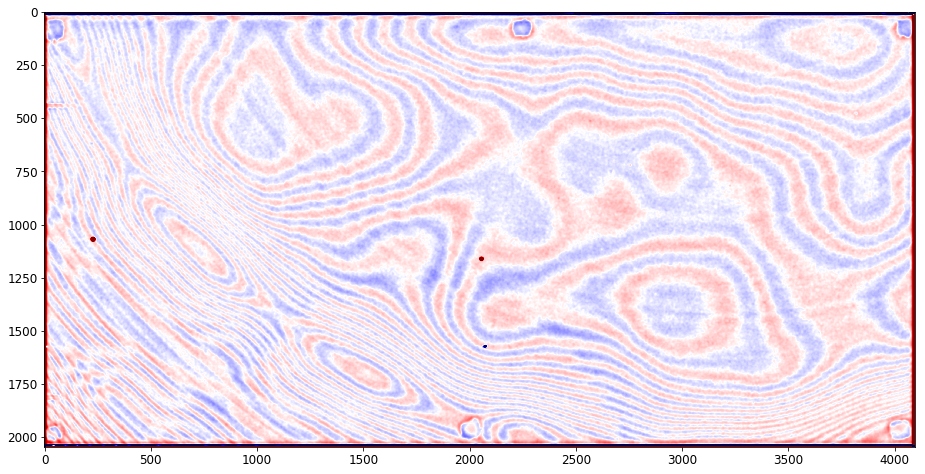

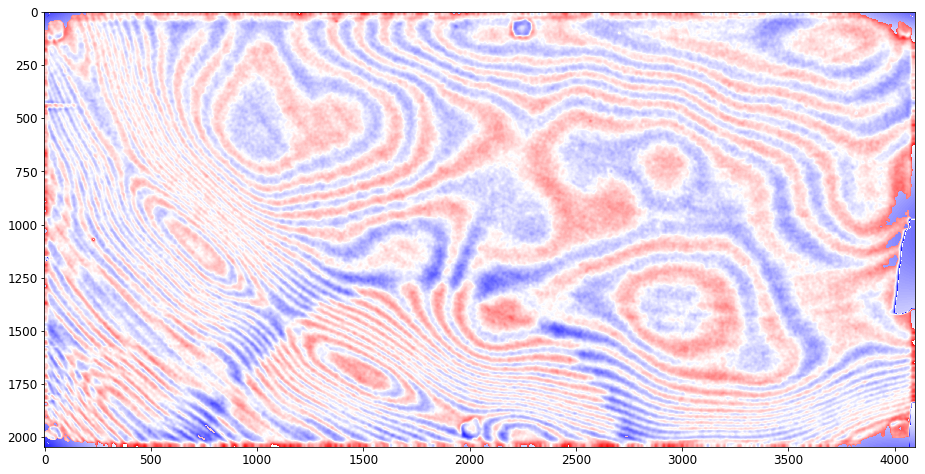

In [24]:
vrange = 5e-3

plt.figure(figsize=(17, 8))
plt.imshow((img_median_smooth).T, cmap='seismic', vmin=-vrange, vmax=vrange)
plt.show()

plt.figure(figsize=(17, 8))
plt.imshow((img_median-img_median_smooth).T, cmap='seismic', vmin=-vrange, vmax=vrange)
plt.show()

# Plot 4-pixel gaussian smoothed fringe image
img_median_4pix_gauss = gaussian_filter((img_median-img_median_smooth), 4, mode='reflect')
plt.figure(figsize=(17, 8))
plt.imshow((img_median_4pix_gauss).T, cmap='seismic', vmin=-vrange, vmax=vrange)
plt.show()

plt.figure(figsize=(17, 8))
plt.imshow((fringe).T, cmap='seismic', vmin=-vrange, vmax=vrange)
plt.show()

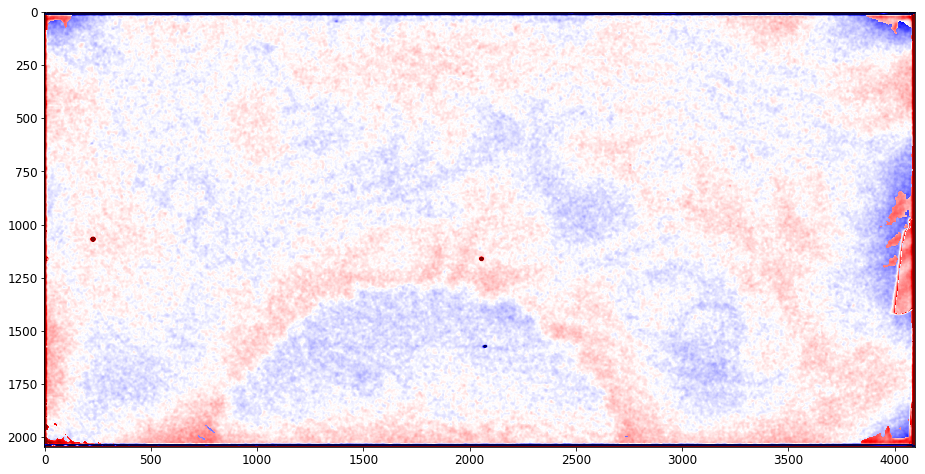

In [25]:
# img_median_4pix_gauss = gaussian_filter((img_median-img_median_smooth), 4, mode='reflect')
plt.figure(figsize=(17, 8))
plt.imshow((img_median_4pix_gauss-fringe).T, cmap='seismic', vmin=-vrange, vmax=vrange)
plt.show()

--------
## Try a different night

In [26]:
# Compute the median stacked image for one specific night
np.random.seed(11)
obs_date = np.random.choice(ccd['obs_date'])
ccd_mask = ccd['obs_date']==obs_date
print(obs_date+':', np.sum(ccd_mask), 'CCDs')

CP20180904: 57 CCDs


In [27]:
img_list = []

for index, ccd_index in enumerate(np.where(ccd_mask)[0]):
    print(index)
    
    # Load CCD image
    img_fn = os.path.join(image_dir, ccd['image_filename'][ccd_index]).strip()
    hdulist = fits.open(img_fn)
    # Some images do not have FRGSCALE in the header
    try:
        frgscale = (hdulist[ccd['image_hdu'][ccd_index]].header)['FRGSCALE']
    except:
        continue
    # w = wcs.WCS(hdulist[ccd['image_hdu'][ccd_index]].header)
    img = hdulist[ccd['image_hdu'][ccd_index]].data
    
    # Load fringe image
    ccdnum = str(ccdnamenumdict[ccd[ccd_index]['ccdname'].strip()]).zfill(2)
    fringe_path = os.path.join(fringe_dir, 'DES17B_20180103_908c062-z-{}_frg.fits'.format(ccdnum))
    fringe = fits.getdata(fringe_path)
    # remove the edge pixels
    fringe = fringe[1:4095, 1:2047]
    
    # Back out the exisiting fringe correction
    img += fringe*frgscale
    
    # Load blob mask
    str_loc = str.find(ccd['image_filename'][ccd_index].strip(), '.fits')
    img_filename_base = ccd['image_filename'][ccd_index].strip()[:str_loc]
    blob_path = os.path.join(blob_dir, 'blob_mask', img_filename_base+'-blobmask.npz')
    blob_data = np.load(blob_path)
    blob = blob_data['hdu'+str(hdu_index).zfill(2)]
    
    # Remove mediam sky
    sky = np.median(img[blob].flatten())
    img = img - sky
    
    # Normalize by frgscale
    img = img/frgscale
    
    # Apply blob mask
    img[~blob] = np.nan

    img_list.append(img)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56


In [28]:
img_median = np.nanmedian(img_list, axis=0)
img_mean = np.nanmean(img_list, axis=0)

# 3-sigma clipping
sky_nmad = nmad(img_median[np.isfinite(img_median)]) # sky level
mask = (img_median<-3*sky_nmad) | (img_median>3*sky_nmad)
img_median1 = img_median.copy()
img_median1[mask] = 0

# Fill in NAN values
mask = ~np.isfinite(img_median)
img_median[mask] = 0
img_median1[mask] = 0
img_mean[mask] = 0
print('number of NAN pixels:', np.sum(mask))

number of NAN pixels: 0


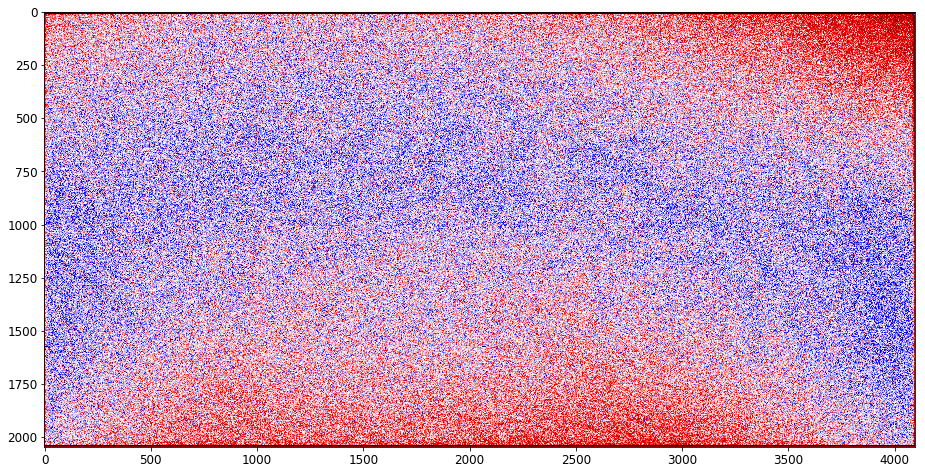

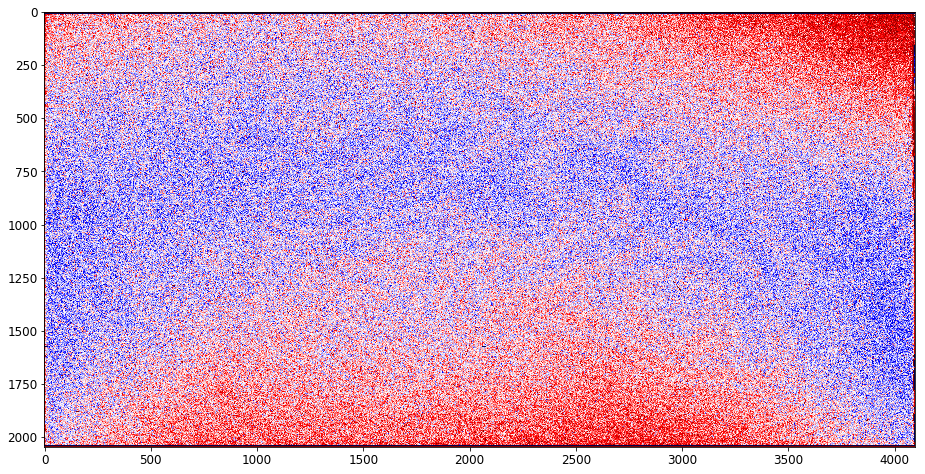

In [29]:
vrange = 1e-2

plt.figure(figsize=(17, 8))
plt.imshow((img_median).T, cmap='seismic', vmin=-vrange, vmax=vrange)
plt.show()

plt.figure(figsize=(17, 8))
plt.imshow((img_mean).T, cmap='seismic', vmin=-vrange, vmax=vrange)
plt.show()

In [30]:
# Remove the large-scale smooth component with gaussian filter

# trim edges
trim_size = 11   # trimmed imagee size need to be multiples of binsize
img_median1 = img_median1[trim_size:(img_median1.shape[0]-trim_size), trim_size:(img_median1.shape[1]-trim_size)]

# downsize the image to speed up gaussian filter
binsize = 1  # no downsizing
# img_median1 = img_median1.reshape((img_median1.shape[0]//binsize, binsize, img_median1.shape[1]//binsize,-1)).mean(axis=3).mean(1)
x_small_grid = trim_size + binsize/2+binsize*np.arange(img_median1.shape[1])
y_small_grid = trim_size + binsize/2+binsize*np.arange(img_median1.shape[0])

# Gaussian filtering
img_median1_smooth = gaussian_filter(img_median1, 120, mode='reflect')

# Convert the downsized smooth image to full size
interp_func = interp2d(x_small_grid, y_small_grid, img_median1_smooth, kind='linear')
x_grid, y_grid = np.arange(img.shape[1]), np.arange(img.shape[0])
img_median_smooth = interp_func(x_grid, y_grid).reshape(img.shape)

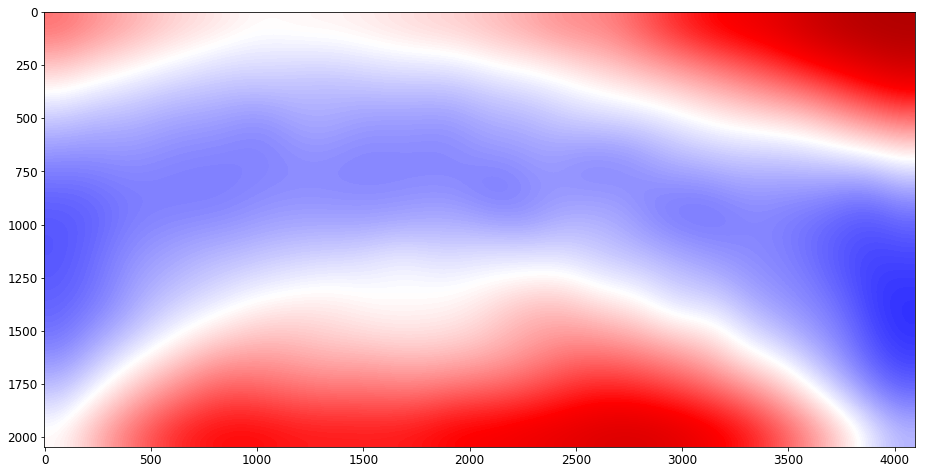

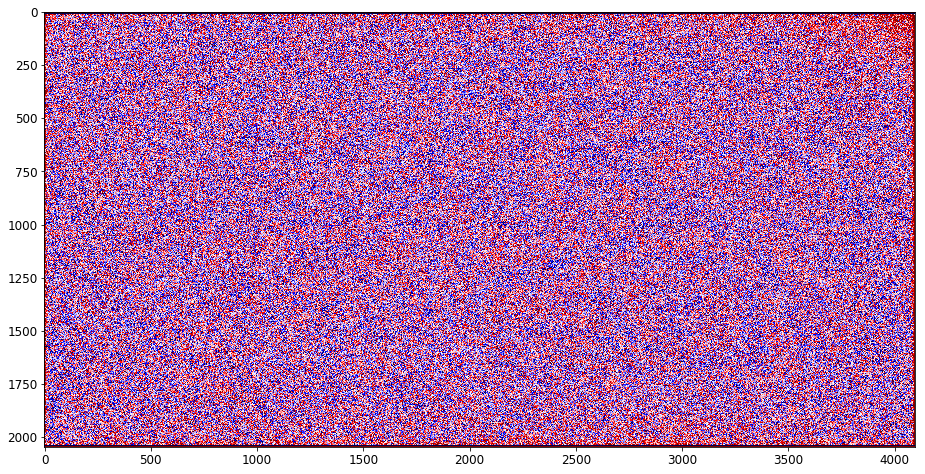

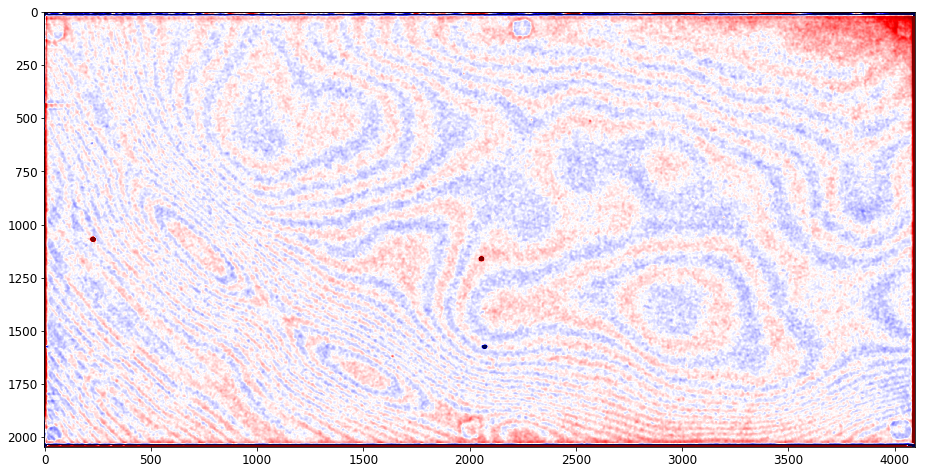

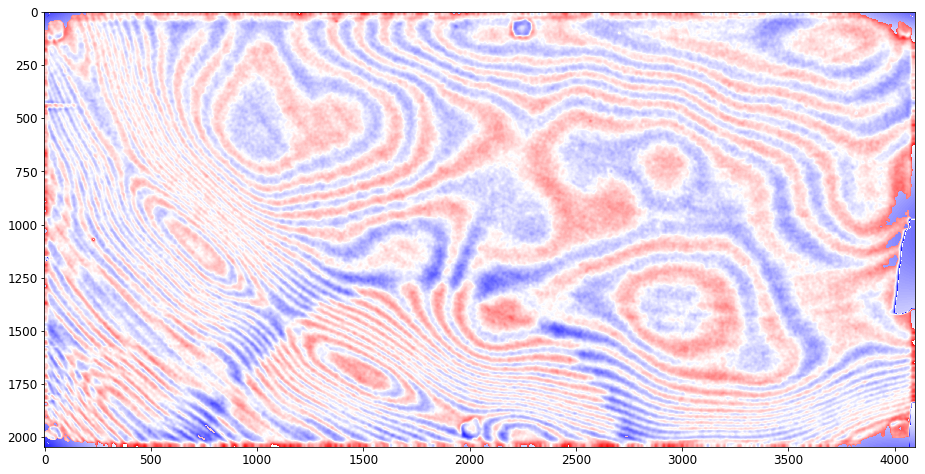

In [31]:
vrange = 5e-3

plt.figure(figsize=(17, 8))
plt.imshow((img_median_smooth).T, cmap='seismic', vmin=-vrange, vmax=vrange)
plt.show()

plt.figure(figsize=(17, 8))
plt.imshow((img_median-img_median_smooth).T, cmap='seismic', vmin=-vrange, vmax=vrange)
plt.show()

# Plot 4-pixel gaussian smoothed fringe image
img_median_4pix_gauss = gaussian_filter((img_median-img_median_smooth), 4, mode='reflect')
plt.figure(figsize=(17, 8))
plt.imshow((img_median_4pix_gauss).T, cmap='seismic', vmin=-vrange, vmax=vrange)
plt.show()

plt.figure(figsize=(17, 8))
plt.imshow((fringe).T, cmap='seismic', vmin=-vrange, vmax=vrange)
plt.show()

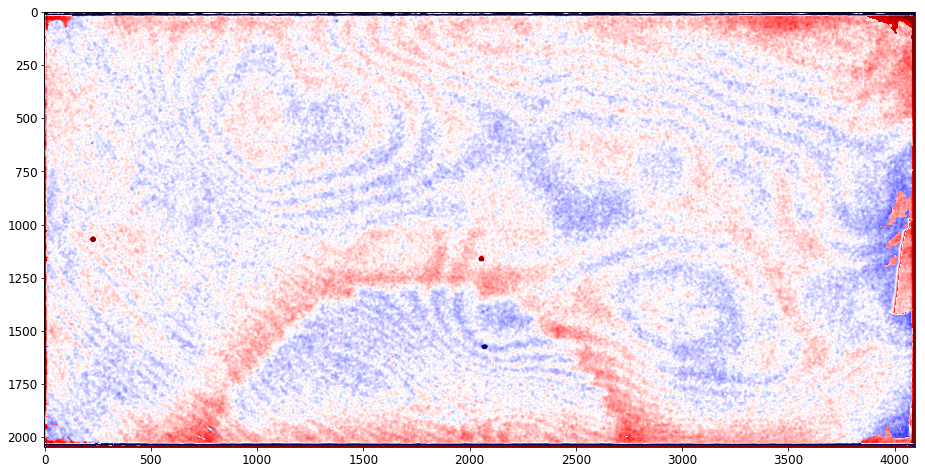

In [32]:
# img_median_4pix_gauss = gaussian_filter((img_median-img_median_smooth), 4, mode='reflect')
plt.figure(figsize=(17, 8))
plt.imshow((img_median_4pix_gauss-fringe).T, cmap='seismic', vmin=-vrange, vmax=vrange)
plt.show()